# Praca Domowa 6 [HW6]
*Bruno Tomusiak*

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv(r"C:\Users\tomus\Desktop\steam_games.csv",
delimiter = ",").dropna().reset_index(drop = True)

### (1) Opis zbioru danych. Wielkość, brakujące dane oraz typy zmiennych.

In [57]:
print(f'Liczba wierszy: {df.shape[0]}\nLiczba kolumn: {df.shape[1]}')

Liczba wierszy: 71429
Liczba kolumn: 21


In [4]:
df.dtypes

steam_appid              int64
name                    object
developers              object
publishers              object
categories              object
genres                  object
required_age             int64
n_achievements           int64
platforms               object
is_released               bool
release_date            object
additional_content      object
total_reviews            int64
total_positive           int64
total_negative           int64
review_score           float64
review_score_desc       object
positive_percentual    float64
metacritic               int64
is_free                   bool
price_initial (USD)    float64
dtype: object

Większość zmiennych jest typu 'object' co wynika z tego, że są to listy, które stanowią zmienne typu multilabel. Poza nimi mamy zmienne numeryczne, oraz jedną typu bool (Prawda/Fałsz)

In [5]:
df.isnull().sum()

steam_appid            0
name                   0
developers             0
publishers             0
categories             0
genres                 0
required_age           0
n_achievements         0
platforms              0
is_released            0
release_date           0
additional_content     0
total_reviews          0
total_positive         0
total_negative         0
review_score           0
review_score_desc      0
positive_percentual    0
metacritic             0
is_free                0
price_initial (USD)    0
dtype: int64

Jak widać nie ma braków danych.

## (2) Analiza zmiennych (statystyka opisowa)

In [6]:
df.describe()

,steam_appid,required_age,n_achievements,total_reviews,total_positive,total_negative,review_score,positive_percentual,metacritic,price_initial (USD)
count,7.142900e+04,71429.000000,71429.000000,7.142900e+04,7.142900e+04,71429.000000,71429.000000,71429.000000,71429.000000,71429.000000
mean,1.613700e+06,2.573227,16.079478,4.102497e+02,3.602238e+02,50.025886,2.192849,46.113290,2.573227,6.528184
std,8.625559e+05,13.591997,138.084319,8.389934e+03,7.409672e+03,1171.055349,3.175885,41.961702,13.591997,13.186426
min,7.300000e+02,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.296400e+05,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.533470e+06,0.000000,0.000000,2.000000e+00,2.000000e+00,0.000000,0.000000,50.000000,0.000000,2.990000
75%,2.383530e+06,0.000000,16.000000,1.900000e+01,1.400000e+01,4.000000,5.000000,88.000000,0.000000,9.990000
max,3.430140e+06,97.000000,9821.000000,1.279700e+06,1.107275e+06,172425.000000,9.000000,100.000000,97.000000,999.980000


Generalne zestawienie podstawowych statystyk zmiennych numerycznych. 

Przechodzimy do krótkiego porównania zmiennej typu bool (released: yes/no), której podział Tak/Nie jest dosyć oczywisty w porównaniu:

In [7]:
releases_yes = round(df.loc[df.is_released == True].shape[0]/df.shape[0]*100,2)
print(f'Released: {releases_yes}% |',
    f'Not Released: {round(100-releases_yes,2)}%')

Released: 81.26% | Not Released: 18.74%


Przyjrzyjmy się bliżej samym zmiennym numerycznym.

In [8]:
numeric_df = df.select_dtypes(exclude=['object','bool'])

In [9]:
numeric_df.median()

steam_appid            1533470.00
required_age                 0.00
n_achievements               0.00
total_reviews                2.00
total_positive               2.00
total_negative               0.00
review_score                 0.00
positive_percentual         50.00
metacritic                   0.00
price_initial (USD)          2.99
dtype: float64

Powyższe statystki są bardzo cenne. Pokazują, że wartości sporej części zmiennych są głównie zerowe. To tłumaczy czemu nie ma braków danych. W przypadku gdy dana gra nie zawierała pewnych elementów (osiągnięcia itp) to przypisywano danym zmiennom wartości zerowe.

In [10]:
numeric_df.quantile([0.25,0.50,0.75])

,steam_appid,required_age,n_achievements,total_reviews,total_positive,total_negative,review_score,positive_percentual,metacritic,price_initial (USD)
0.25,929640.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
0.50,1533470.0,0.0,0.0,2.0,2.0,0.0,0.0,50.0,0.0,2.99
0.75,2383530.0,0.0,16.0,19.0,14.0,4.0,5.0,88.0,0.0,9.99


Kwantyle również potwierdzają tą tezę. W dalszej części raportu skupimy się na zmiennych o niezerowych medianach.

## (3) Analiza zmiennych numerycznych w zależności od dostępności na danej platformie.

In [11]:
df.platforms.value_counts()

platforms
['windows']                    54889
['windows', 'mac', 'linux']     7362
['windows', 'mac']              6539
['windows', 'linux']            2611
['mac']                           21
['linux']                          6
['mac', 'linux']                   1
Name: count, dtype: int64

Tak ilościowo prezentuje się ilościowo dostępność poszczególnych gier.

In [12]:
df2 = df.groupby('platforms')

In [13]:
df2.total_reviews.agg('describe')

,count,mean,std,min,25%,50%,75%,max
platforms,,,,,,,,
['linux'],6.0,8.500000,20.820663,0.0,0.0,0.0,0.0,51.0
"['mac', 'linux']",1.0,63.000000,NaN,63.0,63.0,63.0,63.0,63.0
['mac'],21.0,9.238095,39.373728,0.0,0.0,0.0,2.0,181.0
"['windows', 'linux']",2611.0,728.039065,25312.939429,0.0,0.0,2.0,18.0,1279700.0
"['windows', 'mac', 'linux']",7362.0,811.990356,9500.161641,0.0,1.0,13.0,86.0,543537.0
"['windows', 'mac']",6539.0,653.981954,9475.224799,0.0,0.0,6.0,42.0,475673.0
['windows'],54889.0,312.416859,6188.153042,0.0,0.0,2.0,14.0,571834.0


Wnioski: 
- trzy pierwsze kategorie z uwagi na mało liczną próbkę nie są interesujące. W dalszej analizie nie będę ponownie poruszałtej kwestii
- co ciekawe największa zaobserwowana liczba ocen nie występuje przy najliczniej reprezentowanej grupie (windows), a przy jednej z mniej licznych, przy tej samej kategorii odchylenie standardowe również jest największe (pewnie przez wartości odstające)
- widać też, że większośc gier nie ma wysokiej liczby ocen, przy dwóch najpopularniejszych kategoriach kwantyl rzędu 50% nie przekracza 13!

In [14]:
df2.total_positive.agg('describe')

,count,mean,std,min,25%,50%,75%,max
platforms,,,,,,,,
['linux'],6.0,3.333333,8.164966,0.0,0.0,0.0,0.0,20.0
"['mac', 'linux']",1.0,53.000000,NaN,53.0,53.0,53.0,53.0,53.0
['mac'],21.0,5.571429,23.716179,0.0,0.0,0.0,0.0,109.0
"['windows', 'linux']",2611.0,633.594025,21915.183442,0.0,0.0,2.0,14.0,1107275.0
"['windows', 'mac', 'linux']",7362.0,750.679571,9195.900747,0.0,0.0,9.0,67.0,531256.0
"['windows', 'mac']",6539.0,597.840648,8725.336961,0.0,0.0,4.0,31.5,414683.0
['windows'],54889.0,266.722695,5306.713435,0.0,0.0,1.0,10.0,485431.0


Do analogicznych wniosków można dojść przyglądając się tej kategorii. Również jest to zmienna ilościowa, zatem wyniki są bardzo zbliżone.

In [15]:
df2.positive_percentual.agg('describe')

,count,mean,std,min,25%,50%,75%,max
platforms,,,,,,,,
['linux'],6.0,6.533333,16.003333,0.0,0.0,0.0,0.00,39.2
"['mac', 'linux']",1.0,84.100000,NaN,84.1,84.1,84.1,84.10,84.1
['mac'],21.0,15.961905,30.739721,0.0,0.0,0.0,0.00,100.0
"['windows', 'linux']",2611.0,48.954653,43.379834,0.0,0.0,61.1,92.90,100.0
"['windows', 'mac', 'linux']",7362.0,59.731608,38.545051,0.0,0.0,75.6,91.90,100.0
"['windows', 'mac']",6539.0,53.379829,41.300621,0.0,0.0,69.0,91.65,100.0
['windows'],54889.0,43.301068,41.941598,0.0,0.0,48.6,85.70,100.0


Wnioski:
- przyjmując za wyznacznik jakości średnią, możemy dojść do wniosku, że to gry wydawane na wszystckih trzech platformach są najlepiej odbierane
- odchylenie standardowe znowu jest największe w grupie windows/linuks (dalej wzmacnia to tezę, że jest to kategoria o największej liczbie wartości odstających)
- większa próbka skutkuje średnio gorszymi ocenami, świadczą o tym wyniki platformy windows (kwantyl 75% najmniejszy z głównej czwórki)

In [16]:
df2['price_initial (USD)'].agg('describe')

,count,mean,std,min,25%,50%,75%,max
platforms,,,,,,,,
['linux'],6.0,5.830000,12.003056,0.00,0.00,0.00,3.7425,29.99
"['mac', 'linux']",1.0,4.990000,NaN,4.99,4.99,4.99,4.9900,4.99
['mac'],21.0,9.948095,15.972765,0.00,0.00,0.00,14.9900,49.99
"['windows', 'linux']",2611.0,5.123516,6.510961,0.00,0.00,2.99,7.9900,99.99
"['windows', 'mac', 'linux']",7362.0,10.187775,25.476291,0.00,0.99,4.99,9.9900,199.99
"['windows', 'mac']",6539.0,6.597549,9.782732,0.00,0.00,4.99,9.9900,269.99
['windows'],54889.0,6.094692,11.119004,0.00,0.00,2.99,8.9900,999.98


Wnioski:
- gry wydane na wszystkich trzech platformach są średnio najdroższe, oraz mają wysokie odchylenie standardowe
- kwantyle są raczej do siebie zbliżone co świadczy o podobnych trendach cenowych na każdej z platform.

##  (4) Analiza rozkładu cen dla 5 najpopularniejszych gatunków.

In [17]:
df['genres'] = df['genres'].apply(
    lambda x: [genre.strip().strip("'") for genre in x.strip("[]").split(',')]
)

df_genres = df.explode('genres').rename(columns={'genres':'genre'})
df_genres = df_genres.rename(columns={'price_initial (USD)':'price'})
df_genres = df_genres[['genre','price']]

genres = df_genres.genre.value_counts().head(4).index.tolist()
df_genres = df_genres.loc[df_genres.genre.isin(genres)]

In [18]:
df_genres.genre.value_counts().head(4)

genre
Indie        50665
Action       30986
Adventure    29741
Casual       28093
Name: count, dtype: int64

Dla zobrazowania wyżej przedstawiliśmy licznośc 4 najpopularniejszych gatunków.

Text(0, 0.5, 'Density')

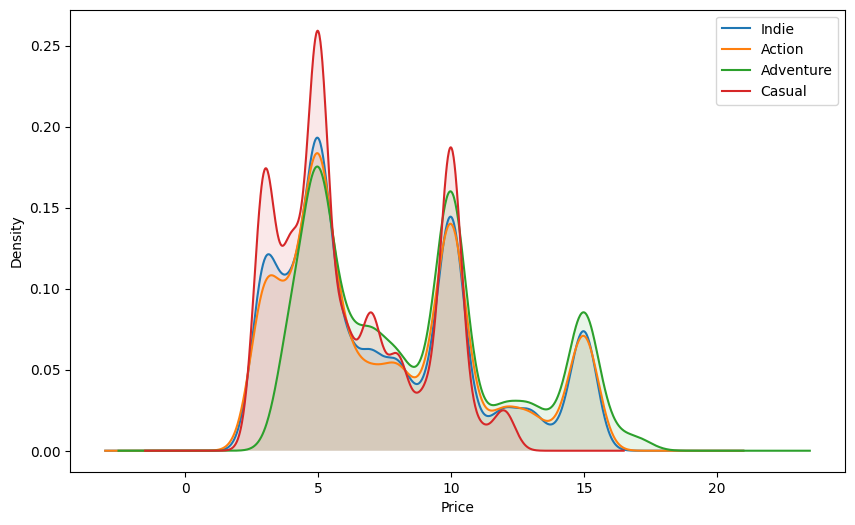

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
for genre in genres:
    subset = df_genres[df_genres.genre == genre]
    subset = subset.loc[(subset.price >= subset.price.quantile(0.5)) & (subset.price <= subset.price.quantile(0.90)) ]
    kde_plot = subset['price'].plot(kind = 'kde', label = genre)
    line = kde_plot.get_lines()[-1]
    x = line.get_xdata()
    y = line.get_ydata()
    plt.fill_between(x, y, alpha=0.1)
plt.legend()
plt.xlabel('Price')
plt.ylabel('Density')

Wnioski:
- pierwsza rzecz jaka rzuca się w oczy to wyrażny podział na pewne koszyki cenowe, większość gier ustala ceny będące wielokrotnościami piątki tj. 5$, 10$ itd.
- średno najtańsze gry z tego zestawienia to te z gatunku *Casual*, w pewnym momencie obserwacje już nie zachodzą
- najdroższe gry na podstawie rozkładu to te z gatunku *Adventure*, ceny 0siągają wartości, których nie osiągają inne gatunki

## (5) Dwie wybrane zależności między zmiennymi.

#### (a) Wydawcy (top 5) a rozkład cen

In [20]:
df_publishers = df[['publishers','price_initial (USD)']]
df_publishers.publishers.value_counts()

publishers
[]                          493
['Big Fish Games']          320
['8floor']                  213
['HH-Games']                138
['Kagura Games']            119
                           ... 
['Krunchy Love Studios']      1
['Bloodbath Studios']         1
['Taylor McCue']              1
['Dreamer']                   1
['Giammnn']                   1
Name: count, Length: 44187, dtype: int64

In [28]:
df_publishers = df_publishers.loc[df_publishers.publishers != '[]']
publishers = df_publishers.publishers.value_counts().head(5).index

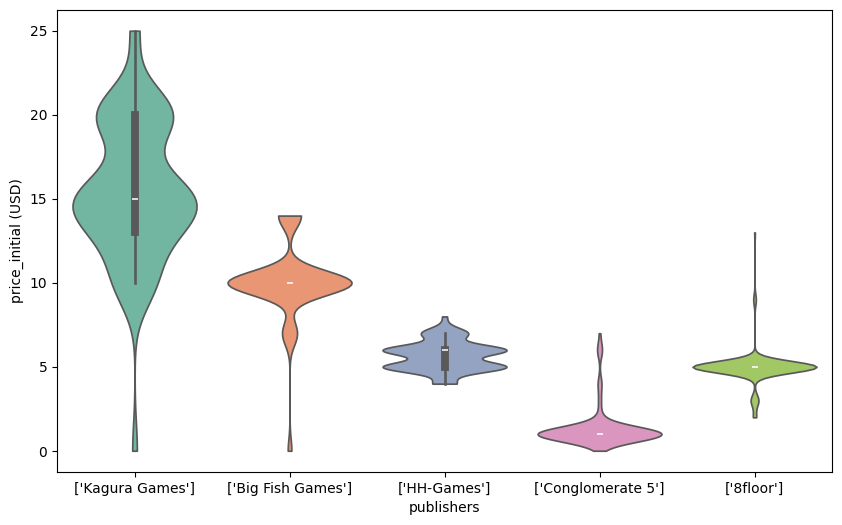

In [34]:
import seaborn as sns
df_publishers = df_publishers.loc[df_publishers.publishers.isin(publishers)]
plt.figure(figsize=(10,6))
sns.violinplot(data=df_publishers, x='publishers', y='price_initial (USD)',hue='publishers' ,palette='Set2', cut=0, legend=False)
plt.show()

Wnioski:
- jest duża rozbieżność cenowa
- średnio najdroższe gry robi *Kagura Games* a najtańsze *Conglomerate 5*

### (b) deweloperzy (top5) a rozkład pozytywnych ocen 

In [50]:
df_developers = df[['developers','positive_percentual']]
df_developers = df_developers.loc[df_developers.developers != '[]']
df_developers.developers.value_counts()

developers
['Creobit']                                                             122
['Choice of Games']                                                     107
['Laush Dmitriy Sergeevich']                                             99
['KOEI TECMO GAMES CO., LTD.']                                           79
['EroticGamesClub']                                                      76
                                                                       ... 
['Motion Game Studio']                                                    1
['Nextout Games']                                                         1
['Ted Bendixson', 'Niall Reynolds', 'Christopher Wu', 'Pixelmancer']      1
['Selecta Play']                                                          1
['DY']                                                                    1
Name: count, Length: 49544, dtype: int64

Ze względów obyczajowo-moralnych wykreślamy piątego developera:

In [51]:
df_developers = df_developers.loc[df_developers.developers != "['EroticGamesClub']"]

In [52]:
developers = df_developers.developers.value_counts().head(5).index

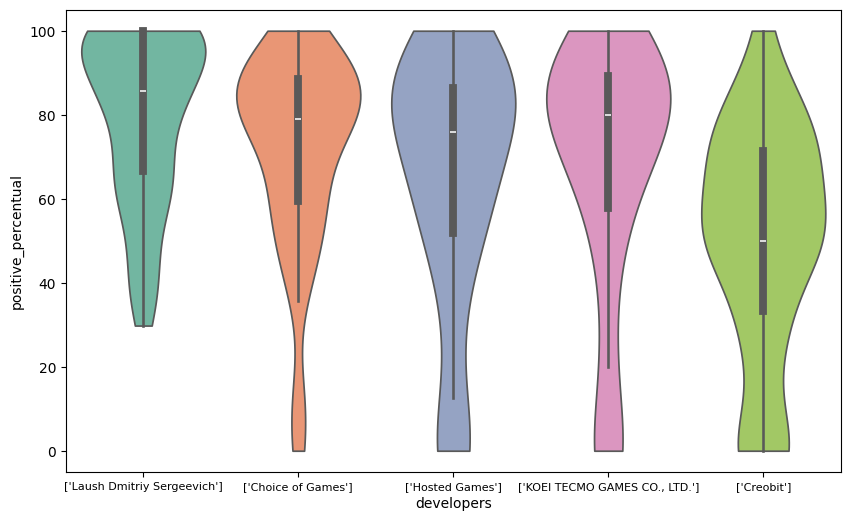

In [55]:
df_developers = df_developers.loc[df_developers.developers.isin(developers)]
plt.figure(figsize=(10,6))
sns.violinplot(data=df_developers, x='developers', y='positive_percentual',hue='developers' ,palette='Set2', cut=0)
plt.xticks(fontsize = 8)
plt.show()

Wnioski:
- Pierwszy developer od lewej ma 'najlepszy' rozkład wśród wybranych developerów
- *Creobit* ma najbardziej nierówny rozkład, znacząco się rózni od pozostałych